╔══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║                                            KNOWLEDGE GRAPH                                                            ║
╚══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝



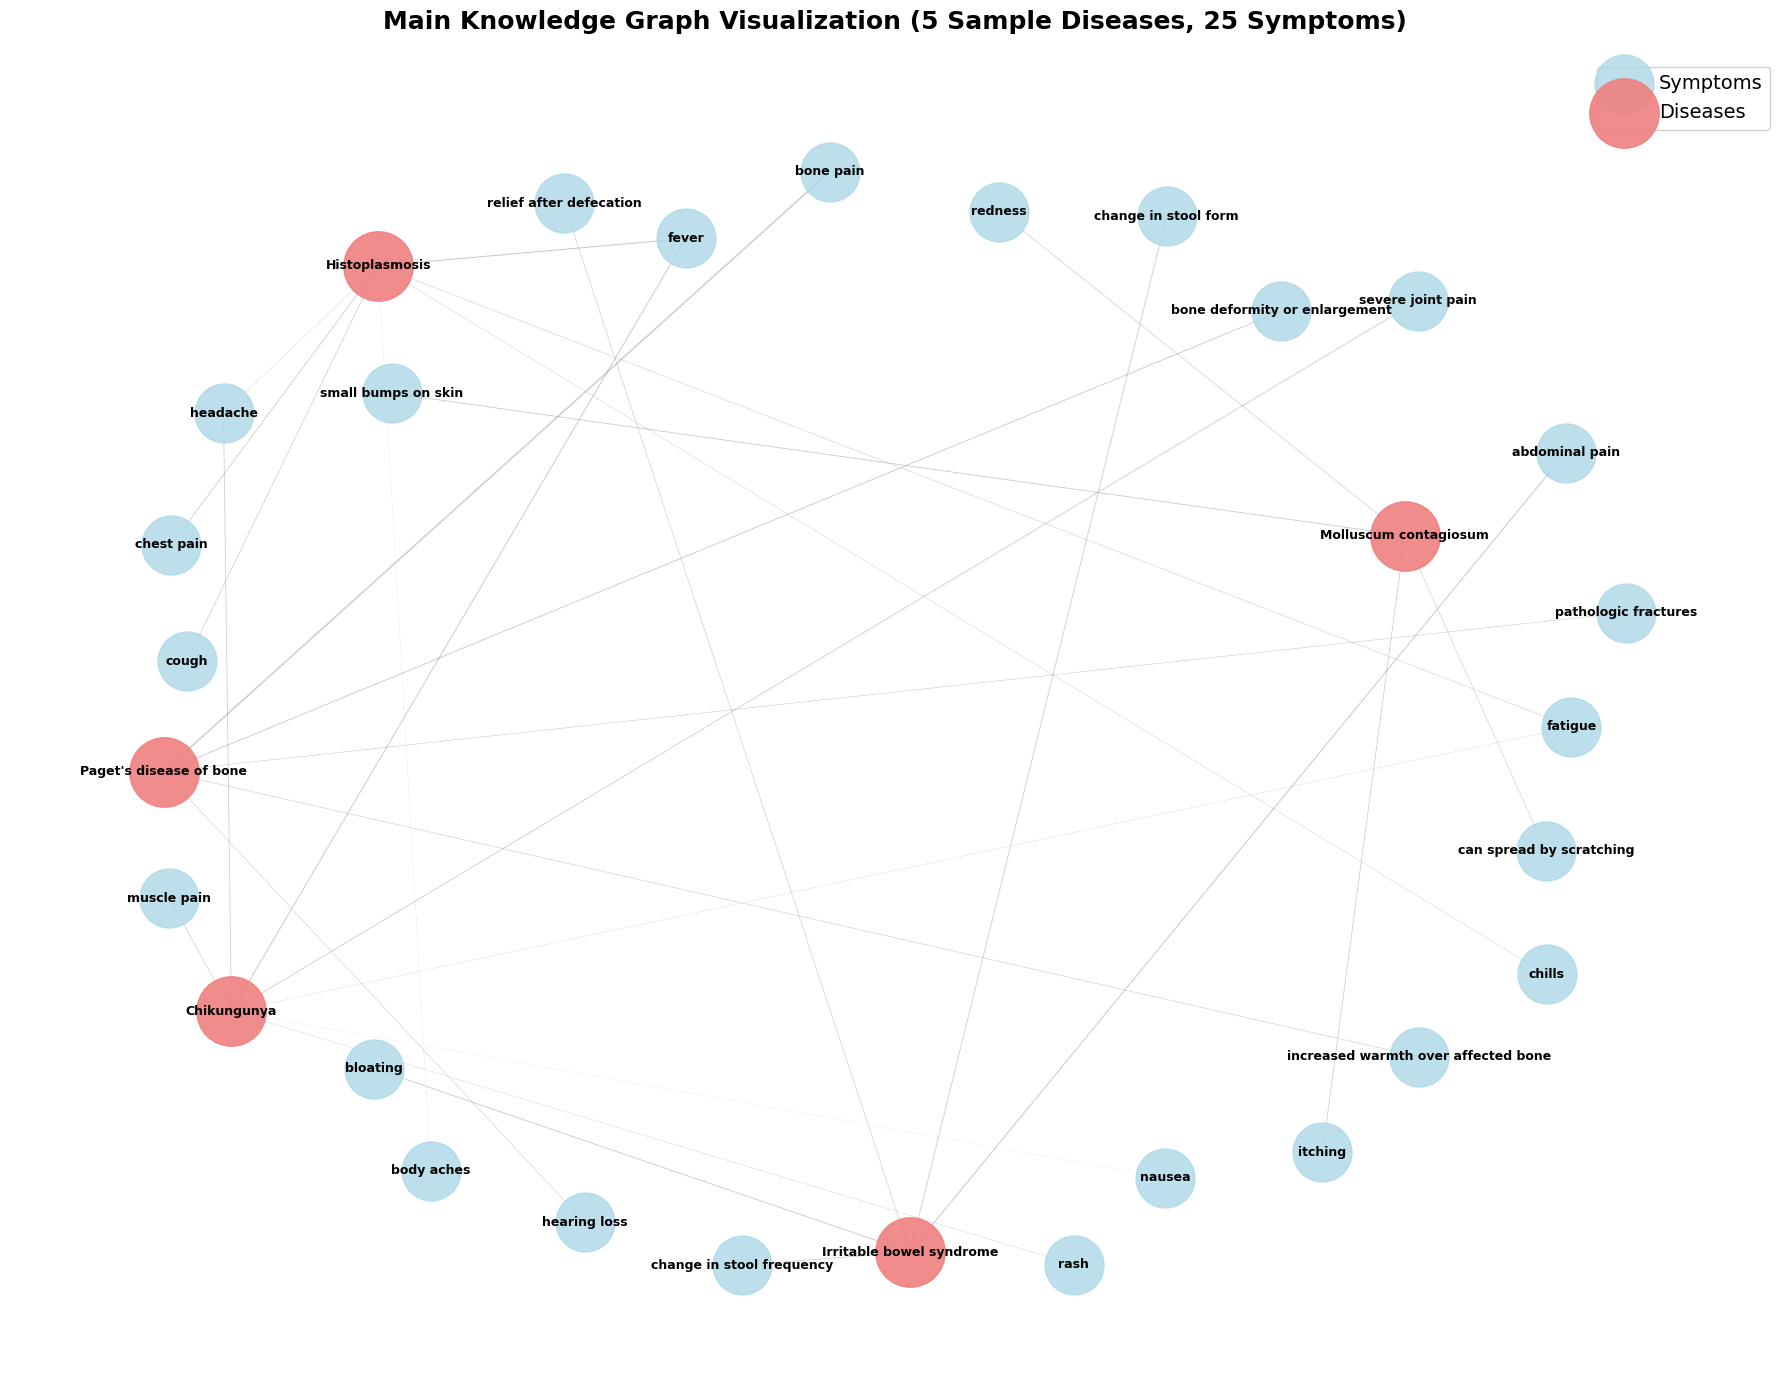




╔══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║                                    DIAGNOSTIC TEST CASES                                                              ║
╚══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝


╔══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║ Test Case 1 – Acute Abdominal Crisis                                                                                 ║
║ Clinical Context: Patient with severe GI symptoms requiring urgent evaluation                                        ║
╚══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝

Input Symptoms: abdominal pain, nausea, vomiting, fever, loss of appetite, rebound tenderness

Rank  Predicted Disease                  Confidence

In [107]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm
from scipy.sparse import hstack, csr_matrix
import lightgbm as lgb


# LOAD DATA (SILENT)

with open('final_disease_symptoms_trimmed.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)

def parse_symptoms(symptom_string):
    symptoms, probs = [], []
    for item in symptom_string.split(', '):
        # Find the last space followed by a number (the probability)
        parts = item.rsplit(' ', 1)
        if len(parts) == 2:
            try:
                prob = float(parts[1])
                symptoms.append(parts[0].strip())
                probs.append(prob)
            except ValueError:
                # If conversion fails, this might be a multi-word symptom
                # Try to find the probability by looking for the last token that's a number
                words = item.split()
                for i in range(len(words) - 1, -1, -1):
                    try:
                        prob = float(words[i])
                        symptom = ' '.join(words[:i]).strip()
                        symptoms.append(symptom)
                        probs.append(prob)
                        break
                    except ValueError:
                        continue
        else:
            # If there's no space, skip this item
            continue
    return symptoms, probs

disease_symptom_list = []
for _, row in df.iterrows():
    symptoms, probs = parse_symptoms(row['Symptoms'])
    for symptom, prob in zip(symptoms, probs):
        disease_symptom_list.append({
            'Disease': row['Diseases'],
            'Symptom': symptom,
            'Probability': prob
        })

ds_df = pd.DataFrame(disease_symptom_list)


# BUILD KNOWLEDGE GRAPH 

G = nx.Graph()

for _, row in ds_df.iterrows():
    G.add_node(row['Disease'], node_type='disease')
    G.add_node(row['Symptom'], node_type='symptom')
    G.add_edge(row['Symptom'], row['Disease'], weight=row['Probability'])


# VISUALIZE MAIN KNOWLEDGE GRAPH
def visualize_main_kg(graph, num_diseases):
    """Visualize main Knowledge Graph"""
    np.random.seed(42)
    all_diseases = [n for n in graph.nodes() if graph.nodes[n].get('node_type') == 'disease']
    sample_diseases = list(np.random.choice(all_diseases, min(num_diseases, len(all_diseases)), replace=False))
    
    connected_symptoms = set()
    for disease in sample_diseases:
        neighbors = list(graph.neighbors(disease))
        connected_symptoms.update(neighbors)
    
    subgraph_nodes = sample_diseases + list(connected_symptoms)
    subgraph = graph.subgraph(subgraph_nodes)
    
    pos = nx.spring_layout(subgraph, k=2, iterations=50, seed=42)
    
    plt.figure(figsize=(18, 14))
    
    symptom_nodes = [n for n in subgraph.nodes() if subgraph.nodes[n].get('node_type') == 'symptom']
    nx.draw_networkx_nodes(subgraph, pos, nodelist=symptom_nodes, 
                          node_color='lightblue', node_size=1800, 
                          node_shape='o', alpha=0.8, label='Symptoms')
    
    disease_nodes = [n for n in subgraph.nodes() if subgraph.nodes[n].get('node_type') == 'disease']
    nx.draw_networkx_nodes(subgraph, pos, nodelist=disease_nodes, 
                          node_color='lightcoral', node_size=2500, 
                          node_shape='o', alpha=0.9, label='Diseases')
    
    edges = subgraph.edges()
    weights = [subgraph[u][v]['weight'] for u, v in edges]
    nx.draw_networkx_edges(subgraph, pos, width=[w*3 for w in weights], 
                          alpha=0.4, edge_color='gray')
    
    nx.draw_networkx_labels(subgraph, pos, font_size=9, font_weight='bold')
    
    plt.title(f"Main Knowledge Graph Visualization ({len(sample_diseases)} Sample Diseases, {len(connected_symptoms)} Symptoms)", 
              fontsize=18, fontweight='bold', pad=20)
    plt.legend(loc='upper right', fontsize=14, framealpha=0.9)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('lightgbm_knowledge_graph.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

print("╔" + "═"*118 + "╗")
print("║" + " "*44 + "KNOWLEDGE GRAPH" + " "*60 + "║")
print("╚" + "═"*118 + "╝\n")
visualize_main_kg(G, num_diseases=5)
print()

#ADVANCED SYMPTOM IMPORTANCE SCORES 

symptom_importance = {}
symptom_stats = {}

for symptom in ds_df['Symptom'].unique():
    symptom_data = ds_df[ds_df['Symptom'] == symptom]
    
    avg_prob = symptom_data['Probability'].mean()
    max_prob = symptom_data['Probability'].max()
    std_prob = symptom_data['Probability'].std()
    num_diseases = symptom_data['Disease'].nunique()
    
    specificity = 1.0 / (1 + np.log1p(num_diseases))
    discriminative_power = std_prob if std_prob > 0 else 0.1
    
    base_score = (avg_prob * 0.5 + max_prob * 0.5)
    importance = base_score * (1 + specificity) * (1 + discriminative_power * 0.3)
    
    symptom_importance[symptom] = importance
    symptom_stats[symptom] = {
        'avg_prob': avg_prob,
        'max_prob': max_prob,
        'std_prob': std_prob,
        'num_diseases': num_diseases,
        'specificity': specificity
    }

# PRE-COMPUTE DISEASE TOP SYMPTOMS

disease_top_symptoms = {}
disease_all_symptoms = {}

for disease in ds_df['Disease'].unique():
    disease_data = ds_df[ds_df['Disease'] == disease].sort_values('Probability', ascending=False)
    top_4 = disease_data.head(4)
    
    disease_top_symptoms[disease] = {
        'symptoms': set(top_4['Symptom'].tolist()),
        'details': top_4[['Symptom', 'Probability']].to_dict('records')
    }
    
    disease_all_symptoms[disease] = disease_data[['Symptom', 'Probability']].to_dict('records')


# STRICT KG REASONING WITH 4→3→2 FALLBACK LOGIC

def kg_predict_disease(symptoms_input, graph, required_count=3, top_k=20):
    """STRICT KG reasoning: Try 4→3→2 symptom matches"""
    disease_scores = defaultdict(lambda: {'score': 0, 'matched': [], 'weights': []})
    
    normalized_input = [s.lower().strip() for s in symptoms_input]
    
    for symptom in symptoms_input:
        matching_nodes = [n for n in graph.nodes() 
                         if graph.nodes[n].get('node_type') == 'symptom' 
                         and symptom.lower() in n.lower()]
        
        for symptom_node in matching_nodes:
            for neighbor in graph.neighbors(symptom_node):
                if graph.nodes[neighbor].get('node_type') == 'disease':
                    weight = graph[symptom_node][neighbor]['weight']
                    importance_factor = symptom_importance.get(symptom_node, 0.5)
                    adjusted_weight = weight * (1 + importance_factor * 0.2)
                    
                    disease_scores[neighbor]['score'] += adjusted_weight
                    disease_scores[neighbor]['matched'].append(symptom_node)
                    disease_scores[neighbor]['weights'].append(adjusted_weight)
    
    for disease, info in disease_scores.items():
        top_4_info = disease_top_symptoms.get(disease, {})
        top_4_symptoms = top_4_info.get('symptoms', set())
        
        matched_in_top4 = []
        for disease_symptom in top_4_symptoms:
            for input_symptom in symptoms_input:
                if (disease_symptom.lower() in input_symptom.lower() or 
                    input_symptom.lower() in disease_symptom.lower()):
                    matched_in_top4.append(disease_symptom)
                    break
        
        info['matched_top4'] = matched_in_top4
        info['top4_count'] = len(matched_in_top4)
    
    if not disease_scores:
        return [], 0
    
    diseases_with_4_match = {
        disease: info for disease, info in disease_scores.items() 
        if info['top4_count'] >= 4
    }
    
    if len(diseases_with_4_match) >= required_count:
        sorted_results = sorted(diseases_with_4_match.items(), 
                              key=lambda x: x[1]['score'], reverse=True)[:top_k]
        return sorted_results, 4
    
    diseases_with_3_match = {
        disease: info for disease, info in disease_scores.items() 
        if info['top4_count'] >= 3
    }
    
    if len(diseases_with_3_match) >= required_count:
        sorted_results = sorted(diseases_with_3_match.items(), 
                              key=lambda x: x[1]['score'], reverse=True)[:top_k]
        return sorted_results, 3
    
    diseases_with_2_match = {
        disease: info for disease, info in disease_scores.items() 
        if info['top4_count'] >= 2
    }
    
    if len(diseases_with_2_match) >= required_count:
        sorted_results = sorted(diseases_with_2_match.items(), 
                              key=lambda x: x[1]['score'], reverse=True)[:top_k]
        return sorted_results, 2
    
    return [], 0


# ENHANCED TRAINING DATA (25,000 SAMPLES)

num_diseases = len(df['Diseases'].unique())
samples_per_disease = 25000 // num_diseases

expanded_samples = []
np.random.seed(42)

disease_info = {}
for disease in df['Diseases'].unique():
    disease_data = ds_df[ds_df['Disease'] == disease]
    symptoms = disease_data['Symptom'].tolist()
    probs = disease_data['Probability'].tolist()
    
    sorted_pairs = sorted(zip(symptoms, probs), key=lambda x: x[1], reverse=True)
    
    disease_info[disease] = {
        'symptoms': [s for s, p in sorted_pairs],
        'probs': dict(sorted_pairs),
        'high_prob_symptoms': [s for s, p in sorted_pairs if p >= 0.15],
        'top_4': [s for s, p in sorted_pairs[:4]],
        'top_6': [s for s, p in sorted_pairs[:6]]
    }

for disease in df['Diseases'].unique():
    info = disease_info[disease]
    all_symptoms = info['symptoms']
    symptom_probs = info['probs']
    high_prob_symptoms = info['high_prob_symptoms']
    top_4 = info['top_4']
    top_6 = info['top_6']
    
    for sample_idx in range(samples_per_disease):
        n_symptoms = np.random.choice([3, 4, 5, 6, 7], p=[0.03, 0.20, 0.45, 0.25, 0.07])
        n_symptoms = min(n_symptoms, len(all_symptoms))
        
        if sample_idx < int(samples_per_disease * 0.95):
            num_top = np.random.choice([3, 4], p=[0.25, 0.75])
            num_top = min(num_top, len(top_4))
            selected_top = np.random.choice(top_4, size=num_top, replace=False).tolist()
            
            remaining = [s for s in all_symptoms if s not in selected_top]
            if remaining and n_symptoms > len(selected_top):
                num_additional = n_symptoms - len(selected_top)
                remaining_prioritized = [s for s in remaining if s in top_6]
                remaining_other = [s for s in remaining if s not in top_6]
                
                if len(remaining_prioritized) >= num_additional:
                    weights = np.array([symptom_probs[s] ** 0.5 for s in remaining_prioritized])
                    weights = weights / weights.sum()
                    additional = np.random.choice(remaining_prioritized, size=num_additional, 
                                                replace=False, p=weights).tolist()
                else:
                    additional = remaining_prioritized.copy()
                    if remaining_other and len(additional) < num_additional:
                        need_more = num_additional - len(additional)
                        weights = np.array([symptom_probs[s] ** 0.7 for s in remaining_other])
                        weights = weights / weights.sum()
                        more = np.random.choice(remaining_other, size=need_more, 
                                              replace=False, p=weights).tolist()
                        additional.extend(more)
                
                selected = selected_top + additional
            else:
                selected = selected_top
        else:
            weights = np.array([symptom_probs[s] ** 0.5 for s in all_symptoms])
            weights = weights / weights.sum()
            selected = np.random.choice(all_symptoms, size=n_symptoms, 
                                       replace=False, p=weights).tolist()
        
        symptom_text = ' '.join(selected)
        
        if len(selected) >= 2:
            bigrams = [f"{selected[i]}_{selected[i+1]}" for i in range(len(selected)-1)]
            symptom_text += ' ' + ' '.join(bigrams)
        
        if len(selected) >= 3:
            trigrams = [f"{selected[i]}_{selected[i+1]}_{selected[i+2]}" 
                       for i in range(len(selected)-2)]
            symptom_text += ' ' + ' '.join(trigrams)
        
        probs_list = [symptom_probs[s] for s in selected]
        importance_list = [symptom_importance.get(s, 0.5) for s in selected]
        
        high_importance_count = len([s for s in selected if s in high_prob_symptoms])
        top4_count = len([s for s in selected if s in top_4])
        top6_count = len([s for s in selected if s in top_6])
        
        q1_prob = np.percentile(probs_list, 25)
        q3_prob = np.percentile(probs_list, 75)
        
        expanded_samples.append({
            'Disease': disease,
            'Symptoms_Text': symptom_text,
            'Count': len(selected),
            'AvgProb': np.mean(probs_list),
            'MaxProb': np.max(probs_list),
            'MinProb': np.min(probs_list),
            'ProbStd': np.std(probs_list),
            'MedianProb': np.median(probs_list),
            'Q1Prob': q1_prob,
            'Q3Prob': q3_prob,
            'WeightedSum': sum([p * symptom_importance.get(s, 0.5) 
                               for s, p in zip(selected, probs_list)]),
            'HighImpCount': high_importance_count,
            'Top4Count': top4_count,
            'Top6Count': top6_count,
            'ProbRange': np.max(probs_list) - np.min(probs_list),
            'AvgImportance': np.mean(importance_list),
            'MaxImportance': np.max(importance_list),
            'MinImportance': np.min(importance_list),
            'ImpStd': np.std(importance_list),
            'ProbImpRatio': np.mean(probs_list) / (np.mean(importance_list) + 1e-6),
            'WeightedAvgProb': np.average(probs_list, weights=[symptom_importance.get(s, 0.5) for s in selected])
        })

expanded_df = pd.DataFrame(expanded_samples)

# ENHANCED FEATURE EXTRACTION

tfidf = TfidfVectorizer(
    max_features=2000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.85,
    sublinear_tf=True,
    norm='l2',
    use_idf=True
)

X_text = tfidf.fit_transform(expanded_df['Symptoms_Text'])

feature_cols = ['Count', 'AvgProb', 'MaxProb', 'MinProb', 'ProbStd', 
                'MedianProb', 'Q1Prob', 'Q3Prob', 'WeightedSum', 
                'HighImpCount', 'Top4Count', 'Top6Count', 'ProbRange', 
                'AvgImportance', 'MaxImportance', 'MinImportance', 
                'ImpStd', 'ProbImpRatio', 'WeightedAvgProb']

X_num = expanded_df[feature_cols].values
X = hstack([X_text, csr_matrix(X_num)])
y = expanded_df['Disease']

# TRAIN ENHANCED LIGHTGBM 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    max_depth=12,
    learning_rate=0.02,
    num_leaves=80,
    subsample=0.90,
    colsample_bytree=0.90,
    min_child_samples=8,
    reg_alpha=0.2,
    reg_lambda=1.5,
    random_state=42,
    n_jobs=-1,
    verbosity=-1,
    class_weight='balanced',
    boosting_type='gbdt',
    min_split_gain=0.01,
    min_child_weight=0.001
)

lgb_model.fit(X_train, y_train_encoded)

lgb_pred_encoded = lgb_model.predict(X_test)
lgb_pred = label_encoder.inverse_transform(lgb_pred_encoded)
lgb_accuracy = accuracy_score(y_test, lgb_pred)
lgb_f1 = f1_score(y_test, lgb_pred, average='weighted')

lgb_proba_test = lgb_model.predict_proba(X_test)
top3_correct = sum(y_test_encoded[i] in np.argsort(lgb_proba_test[i])[-3:] 
                   for i in range(len(y_test)))
top3_accuracy = top3_correct / len(y_test)


# ENHANCED HYBRID PREDICTION

def hybrid_predict(symptoms_input, top_k=3):
    """Enhanced hybrid prediction with rank-based ML boosting"""
    
    kg_results, match_level = kg_predict_disease(symptoms_input, G, required_count=top_k, top_k=20)
    kg_scores = {}
    kg_details = {}
    
    for disease, info in kg_results:
        kg_scores[disease] = info['score']
        kg_details[disease] = {
            'matched': info['matched'],
            'weights': info['weights'],
            'match_count': len(info['matched']),
            'matched_top4': info.get('matched_top4', []),
            'top4_count': info.get('top4_count', 0)
        }
    
    if kg_scores:
        max_kg = max(kg_scores.values())
        kg_scores = {k: v/max_kg for k, v in kg_scores.items()}
    
    symptom_text = ' '.join(symptoms_input)
    
    if len(symptoms_input) >= 2:
        bigrams = [f"{symptoms_input[i]}_{symptoms_input[i+1]}" 
                  for i in range(len(symptoms_input)-1)]
        symptom_text += ' ' + ' '.join(bigrams)
    
    if len(symptoms_input) >= 3:
        trigrams = [f"{symptoms_input[i]}_{symptoms_input[i+1]}_{symptoms_input[i+2]}" 
                   for i in range(len(symptoms_input)-2)]
        symptom_text += ' ' + ' '.join(trigrams)
    
    X_text_vec = tfidf.transform([symptom_text])
    
    # Build aligned symptom_probs and importance_scores for ALL input symptoms
    symptom_probs = []
    importance_scores = []
    
    for s in symptoms_input:
        if s in ds_df['Symptom'].values:
            prob = ds_df[ds_df['Symptom'] == s]['Probability'].mean()
        else:
            prob = 0.5  # Default for unknown symptoms
        symptom_probs.append(prob)
        importance_scores.append(symptom_importance.get(s, 0.5))
    
    if not symptom_probs:
        symptom_probs = [0.5]
        importance_scores = [0.5]
    
    avg_prob = np.mean(symptom_probs)
    max_prob = np.max(symptom_probs)
    min_prob = np.min(symptom_probs)
    prob_std = np.std(symptom_probs) if len(symptom_probs) > 1 else 0.0
    median_prob = np.median(symptom_probs)
    q1_prob = np.percentile(symptom_probs, 25)
    q3_prob = np.percentile(symptom_probs, 75)
    
    weighted_sum = sum([p * imp for p, imp in zip(symptom_probs, importance_scores)])
    prob_range = max_prob - min_prob
    
    avg_importance = np.mean(importance_scores)
    max_importance = np.max(importance_scores)
    min_importance = np.min(importance_scores)
    imp_std = np.std(importance_scores) if len(importance_scores) > 1 else 0.0
    prob_imp_ratio = avg_prob / (avg_importance + 1e-6)
    
    high_prob_symptoms = [s for s in symptoms_input if s in ds_df['Symptom'].values 
                         and ds_df[ds_df['Symptom'] == s]['Probability'].max() >= 0.15]
    
    weighted_avg_prob = np.average(symptom_probs, weights=importance_scores)
    
    X_num_vec = np.array([[len(symptoms_input), avg_prob, max_prob, min_prob, prob_std, 
                          median_prob, q1_prob, q3_prob, weighted_sum, 
                          len(high_prob_symptoms), 0, 0, prob_range, 
                          avg_importance, max_importance, min_importance, 
                          imp_std, prob_imp_ratio, weighted_avg_prob]])
    
    X_vec = hstack([X_text_vec, csr_matrix(X_num_vec)])
    
    lgb_proba = lgb_model.predict_proba(X_vec)[0]
    
    lgb_proba_log = np.log(lgb_proba + 1e-10)
    temperature = 3.5
    lgb_proba_scaled = np.exp(lgb_proba_log / temperature)
    lgb_proba_scaled = lgb_proba_scaled / lgb_proba_scaled.sum()
    
    uniform_dist = np.ones_like(lgb_proba_scaled) / len(lgb_proba_scaled)
    lgb_proba_smoothed = 0.80 * lgb_proba_scaled + 0.20 * uniform_dist
    lgb_proba_smoothed = lgb_proba_smoothed / lgb_proba_smoothed.sum()
    
    ml_scores_raw = {label_encoder.classes_[i]: lgb_proba_smoothed[i] 
                     for i in range(len(lgb_proba_smoothed))}
    
    if kg_scores:
        kg_diseases = list(kg_scores.keys())
        ml_scores_for_kg = {disease: ml_scores_raw.get(disease, 1e-10) 
                           for disease in kg_diseases}
        
        sorted_ml = sorted(ml_scores_for_kg.items(), key=lambda x: x[1], reverse=True)
        
        ml_scores_powered = {}
        for disease, score in ml_scores_for_kg.items():
            powered_score = score ** 0.35
            ml_scores_powered[disease] = powered_score
        
        ml_scores_boosted = {}
        for rank, (disease, _) in enumerate(sorted_ml, 1):
            base_score = ml_scores_powered[disease]
            
            if rank == 1:
                boost = 2.2
            elif rank == 2:
                boost = 2.0
            elif rank == 3:
                boost = 1.8
            elif rank <= 5:
                boost = 1.5
            elif rank <= 10:
                boost = 1.3
            else:
                boost = 1.0
            
            ml_scores_boosted[disease] = base_score * boost
        
        ml_sum = sum(ml_scores_boosted.values())
        if ml_sum > 0:
            ml_scores = {disease: score/ml_sum for disease, score in ml_scores_boosted.items()}
        else:
            ml_scores = {disease: 1.0/len(kg_diseases) for disease in kg_diseases}
        
        kg_sorted = sorted(kg_scores.items(), key=lambda x: x[1], reverse=True)
        top_kg_diseases = [d for d, _ in kg_sorted[:5]]
        
        ml_scores_final = {}
        for disease in kg_diseases:
            score = ml_scores[disease]
            
            if disease in top_kg_diseases:
                kg_rank = top_kg_diseases.index(disease) + 1
                if kg_rank == 1:
                    score *= 2.0
                elif kg_rank == 2:
                    score *= 1.8
                elif kg_rank == 3:
                    score *= 1.6
                else:
                    score *= 1.4
            
            ml_scores_final[disease] = score
        
        ml_sum_final = sum(ml_scores_final.values())
        ml_scores = {d: s/ml_sum_final for d, s in ml_scores_final.items()}
        
    else:
        ml_scores = ml_scores_raw
    
    if not kg_scores:
        ml_top = sorted(ml_scores_raw.items(), key=lambda x: x[1], reverse=True)[:top_k]
        return {
            'predictions': ml_top,
            'kg_contribution': {},
            'ml_contribution': ml_scores_raw,
            'kg_details': {},
            'ml_confidence': np.max(lgb_proba_smoothed),
            'weights': {'kg': 0, 'ml': 1.0},
            'match_level': 0,
            'message': 'Using ML-only predictions (no symptom matches in KG)'
        }
    
    ml_confidence = np.max(lgb_proba_smoothed)
    if ml_confidence > 0.80:
        weights = {'kg': 0.35, 'ml': 0.65}
    elif ml_confidence > 0.65:
        weights = {'kg': 0.45, 'ml': 0.55}
    elif ml_confidence > 0.50:
        weights = {'kg': 0.55, 'ml': 0.45}
    else:
        weights = {'kg': 0.65, 'ml': 0.35}
    
    kg_top5 = [d for d, _ in sorted(kg_scores.items(), key=lambda x: x[1], reverse=True)[:5]]
    ml_top5 = [d for d, _ in sorted(ml_scores.items(), key=lambda x: x[1], reverse=True)[:5]]
    
    combined_scores = {}
    
    for disease in kg_scores.keys():
        kg_score = kg_scores.get(disease, 0) * weights['kg']
        ml_score = ml_scores.get(disease, 0) * weights['ml']
        
        base_score = kg_score + ml_score
        
        match_count = kg_details[disease]['match_count']
        match_ratio = match_count / len(symptoms_input)
        
        if match_ratio == 1.0:
            match_bonus = 1.50
        elif match_ratio >= 0.85:
            match_bonus = 1.30
        elif match_ratio >= 0.70:
            match_bonus = 1.15
        else:
            match_bonus = 1.05
        
        consensus_bonus = 1.0
        if disease in kg_top5 and disease in ml_top5:
            kg_rank = kg_top5.index(disease) + 1
            ml_rank = ml_top5.index(disease) + 1
            if kg_rank <= 2 and ml_rank <= 2:
                consensus_bonus = 1.50
            elif kg_rank <= 3 and ml_rank <= 3:
                consensus_bonus = 1.35
            elif kg_rank <= 5 and ml_rank <= 5:
                consensus_bonus = 1.20
        
        combined_scores[disease] = base_score * match_bonus * consensus_bonus
    
    top_predictions = sorted(combined_scores.items(), 
                            key=lambda x: x[1], reverse=True)[:top_k]
    
    total_score = sum(score for _, score in top_predictions)
    if total_score > 1.0:
        top_predictions = [(disease, score/total_score) for disease, score in top_predictions]
    
    return {
        'predictions': top_predictions,
        'kg_contribution': kg_scores,
        'ml_contribution': ml_scores,
        'kg_details': kg_details,
        'ml_confidence': ml_confidence,
        'weights': weights,
        'match_level': match_level
    }

# CONDENSED DIAGNOSTIC REPORT 

def diagnose_patient_condensed(symptoms_list, case_name="", case_emoji="", case_description=""):
    """Condensed diagnostic report format with FIXED matched symptoms from input"""
    
    result = hybrid_predict(symptoms_list, top_k=3)
    
    if not result['predictions']:
        print(f"\n  {result.get('message', 'No diseases found')}")
        return result
    
    # Match level and weights
    match_level = result.get('match_level', 0)
    if match_level == 4:
        match_info = "4/4"
    elif match_level == 3:
        match_info = "3/4"
    elif match_level == 2:
        match_info = "2/4"
    else:
        match_info = "N/A"
    
    kg_pct = int(result['weights']['kg'] * 100)
    ml_pct = int(result['weights']['ml'] * 100)
    
    # Build table
    table_data = []
    for rank, (disease, score) in enumerate(result['predictions'], 1):
        kg_detail = result['kg_details'].get(disease, {})
        
        # Get the actual matched symptoms from KG
        matched_kg_symptoms = kg_detail.get('matched', [])
        
        # Count matches more accurately
        match_count = len(matched_kg_symptoms)
        match_ratio = f"{match_count}/{len(symptoms_list)}"
        if match_count > 0:
            match_pct = int((match_count / len(symptoms_list)) * 100)
            match_ratio += f" ({match_pct}%)"
        
        # Match input symptoms with KG matched symptoms - improved matching logic
        matched_from_input = []
        for input_symptom in symptoms_list:
            # Normalize input symptom
            input_lower = input_symptom.lower().strip()
            
            # Check if this input symptom matches any KG symptom
            for kg_symptom in matched_kg_symptoms:
                kg_lower = kg_symptom.lower().strip()
                
                # Check for exact match or partial match in either direction
                if (input_lower == kg_lower or 
                    input_lower in kg_lower or 
                    kg_lower in input_lower or
                    # Also check for common variations (e.g., "joint pain" vs "pain in joints")
                    all(word in kg_lower for word in input_lower.split()) or
                    all(word in input_lower for word in kg_lower.split())):
                    if input_symptom not in matched_from_input:
                        matched_from_input.append(input_symptom)
                    break
        
        # Format all matched symptoms in one line with checkmarks
        top_symptoms_str = ', '.join([f"✓ {s}" for s in matched_from_input])
        
        table_data.append({
            'rank': rank,
            'disease': disease,
            'confidence': f"{score*100:.1f}%",
            'kg_ml': f"{kg_pct}–{ml_pct}",
            'match_ratio': match_ratio,
            'symptoms_matched': top_symptoms_str
        })
    
    return {
        'result': result,
        'case_name': case_name,
        'case_emoji': case_emoji,
        'case_description': case_description,
        'symptoms': symptoms_list,
        'table_data': table_data,
        'match_level': match_info,
        'weights': f"KG={kg_pct}%, ML={ml_pct}%"
    }


print("\n\n╔" + "═"*118 + "╗")
print("║" + " "*36 + "DIAGNOSTIC TEST CASES" + " "*62 + "║")
print("╚" + "═"*118 + "╝\n")

showcase_cases = []

# ============================================================================
# CASE 1: PERFECT MATCH - Appendicitis (All 6 Top Symptoms Present)
# ============================================================================
case1 = diagnose_patient_condensed(
    ['abdominal pain', 'nausea', 'vomiting', 'fever', 'loss of appetite', 'rebound tenderness'],
    case_name="Test Case 1 – Acute Abdominal Crisis",
    case_emoji="",
    case_description="Patient with severe GI symptoms requiring urgent evaluation"
)
showcase_cases.append(case1)

# ============================================================================
# CASE 2: CARDIOVASCULAR CRISIS - Multiple Overlapping Conditions
# ============================================================================
case2 = diagnose_patient_condensed(
    ['chest pain', 'breathlessness', 'sweating', 'palpitations', 'dizziness', 'nausea'],
    case_name="Test Case 2 – Cardiovascular Crisis ",
    case_emoji="",
    case_description="Patient with acute chest symptoms and cardiac risk"
)
showcase_cases.append(case2)

# ============================================================================
# CASE 3: METABOLIC DISORDER - Diabetes (Highly Specific Symptoms)
# ============================================================================
case4 = diagnose_patient_condensed(
    ['polyuria', 'polydipsia', 'fatigue', 'blurred vision', 'weight loss'],
    case_name="Test Case 3 – Metabolic Disorder",
    case_emoji="",
    case_description="Chronic metabolic condition with high blood glucose levels"
)
showcase_cases.append(case4)

# ============================================================================
# CASE 4: COMMON COLD - High Ambiguity (Tests KG-ML Balance)
# ============================================================================
case5 = diagnose_patient_condensed(
    ['fever', 'cough', 'sore throat', 'nasal congestion', 'headache', 'fatigue'],
    case_name="Test Case 4 – Upper Respiratory Infection",
    case_emoji="",
    case_description="Mild viral illness with upper respiratory symptoms"
)
showcase_cases.append(case5)

# Case 5: Autoimmune/Rheumatologic Condition (SLE)
case5 = diagnose_patient_condensed(
    ['fatigue', 'joint pain', 'rash', 'fever', 'sensitivity to sunlight', 'hair loss'],
    case_name="Test Case 5 – Autoimmune Presentation",
    case_emoji="",
    case_description="32-year-old female with symmetric joint pain, facial rash, and constitutional symptoms"
)
showcase_cases.append(case5)



# Display all cases with detailed formatting
for idx, case in enumerate(showcase_cases, 1):
    print("\n╔" + "═"*118 + "╗")
    case_line = f" {case['case_name']}"
    padding1 = 118 - len(case_line)
    print(f"║{case_line}{' '*padding1}║")
    
    context_line = f" Clinical Context: {case['case_description']}"
    padding2 = 118 - len(context_line)
    print(f"║{context_line}{' '*padding2}║")
    print("╚" + "═"*118 + "╝")
    print(f"\nInput Symptoms: {', '.join(case['symptoms'])}\n")
    
    # Table header
    print(f"{'Rank':<6}{'Predicted Disease':<35}{'Confidence':<12}{'KG–ML (%)':<12}{'Match':<12}Matched Symptoms")
    print("─" * 120)
    
    # Table rows
    for i, row in enumerate(case['table_data']):
        disease = row['disease']
        symptoms = row['symptoms_matched']
        
        print(f"{row['rank']:<6}{disease:<35}{row['confidence']:<12}{row['kg_ml']:<12}{row['match_ratio']:<12}{symptoms}")
    
    print()

# ============================================================================
# PERFORMANCE SUMMARY TABLE
# ============================================================================

print("\n╔" + "═"*118 + "╗")
print("║" + " "*43 + "PERFORMANCE SUMMARY" + " "*55 + "║")
print("╚" + "═"*118 + "╝\n")

print("┌" + "─"*50 + "┬" + "─"*25 + "┐")
print(f"│{'Metric':<50}│{'Value':<25}│")
print("├" + "─"*50 + "┼" + "─"*25 + "┤")
samples_str = f"{len(expanded_df):,}"
features_str = f"{X.shape[1]:,}"
print(f"│{'Training Samples':<50}│{samples_str:<25}│")
print(f"│{'Features':<50}│{features_str:<25}│")
print(f"│{'Accuracy (Top-1)':<50}│{f'{lgb_accuracy*100:.2f}%':<25}│")
print(f"│{'Accuracy (Top-3)':<50}│{f'{top3_accuracy*100:.2f}%':<25}│")
print(f"│{'Weighted F1 Score':<50}│{f'{lgb_f1:.4f}':<25}│")
print(f"│{'Model Used':<50}│{'LightGBM':<25}│")
print("└" + "─"*50 + "┴" + "─"*25 + "┘")
print()


╔══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║                                            KNOWLEDGE GRAPH                                                            ║
╚══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝



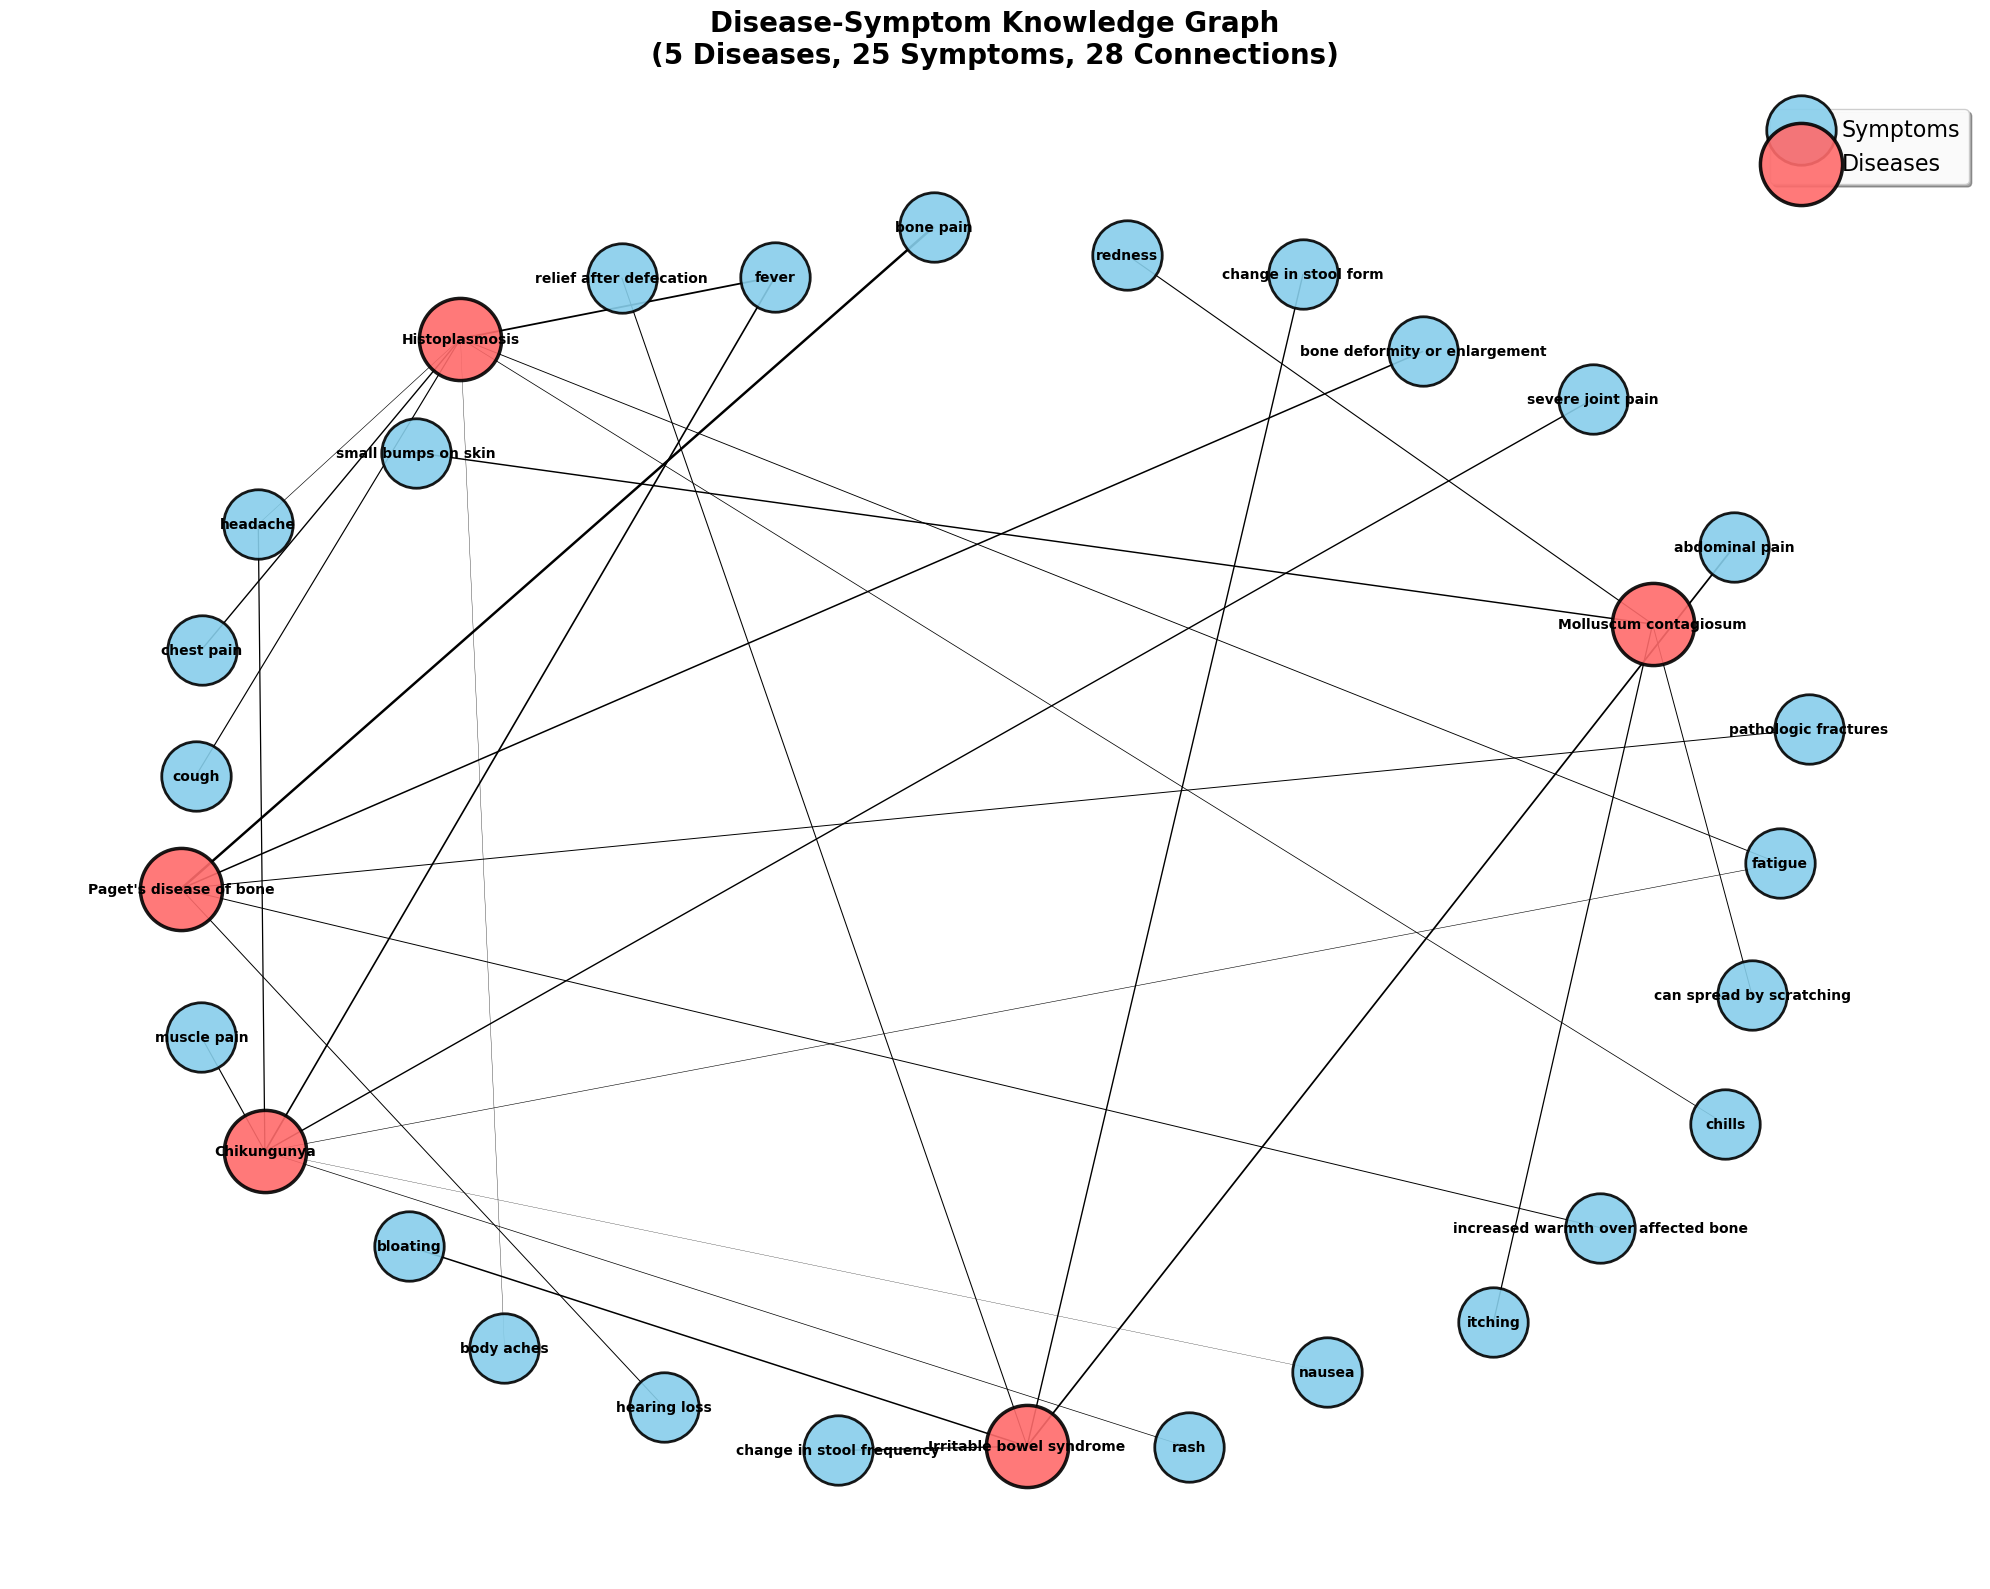



╔══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║                                      COMPLETE KNOWLEDGE GRAPH                                                        ║
╚══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝

Total Diseases: 175
Total Unique Symptoms: 426
Total Connections: 1143



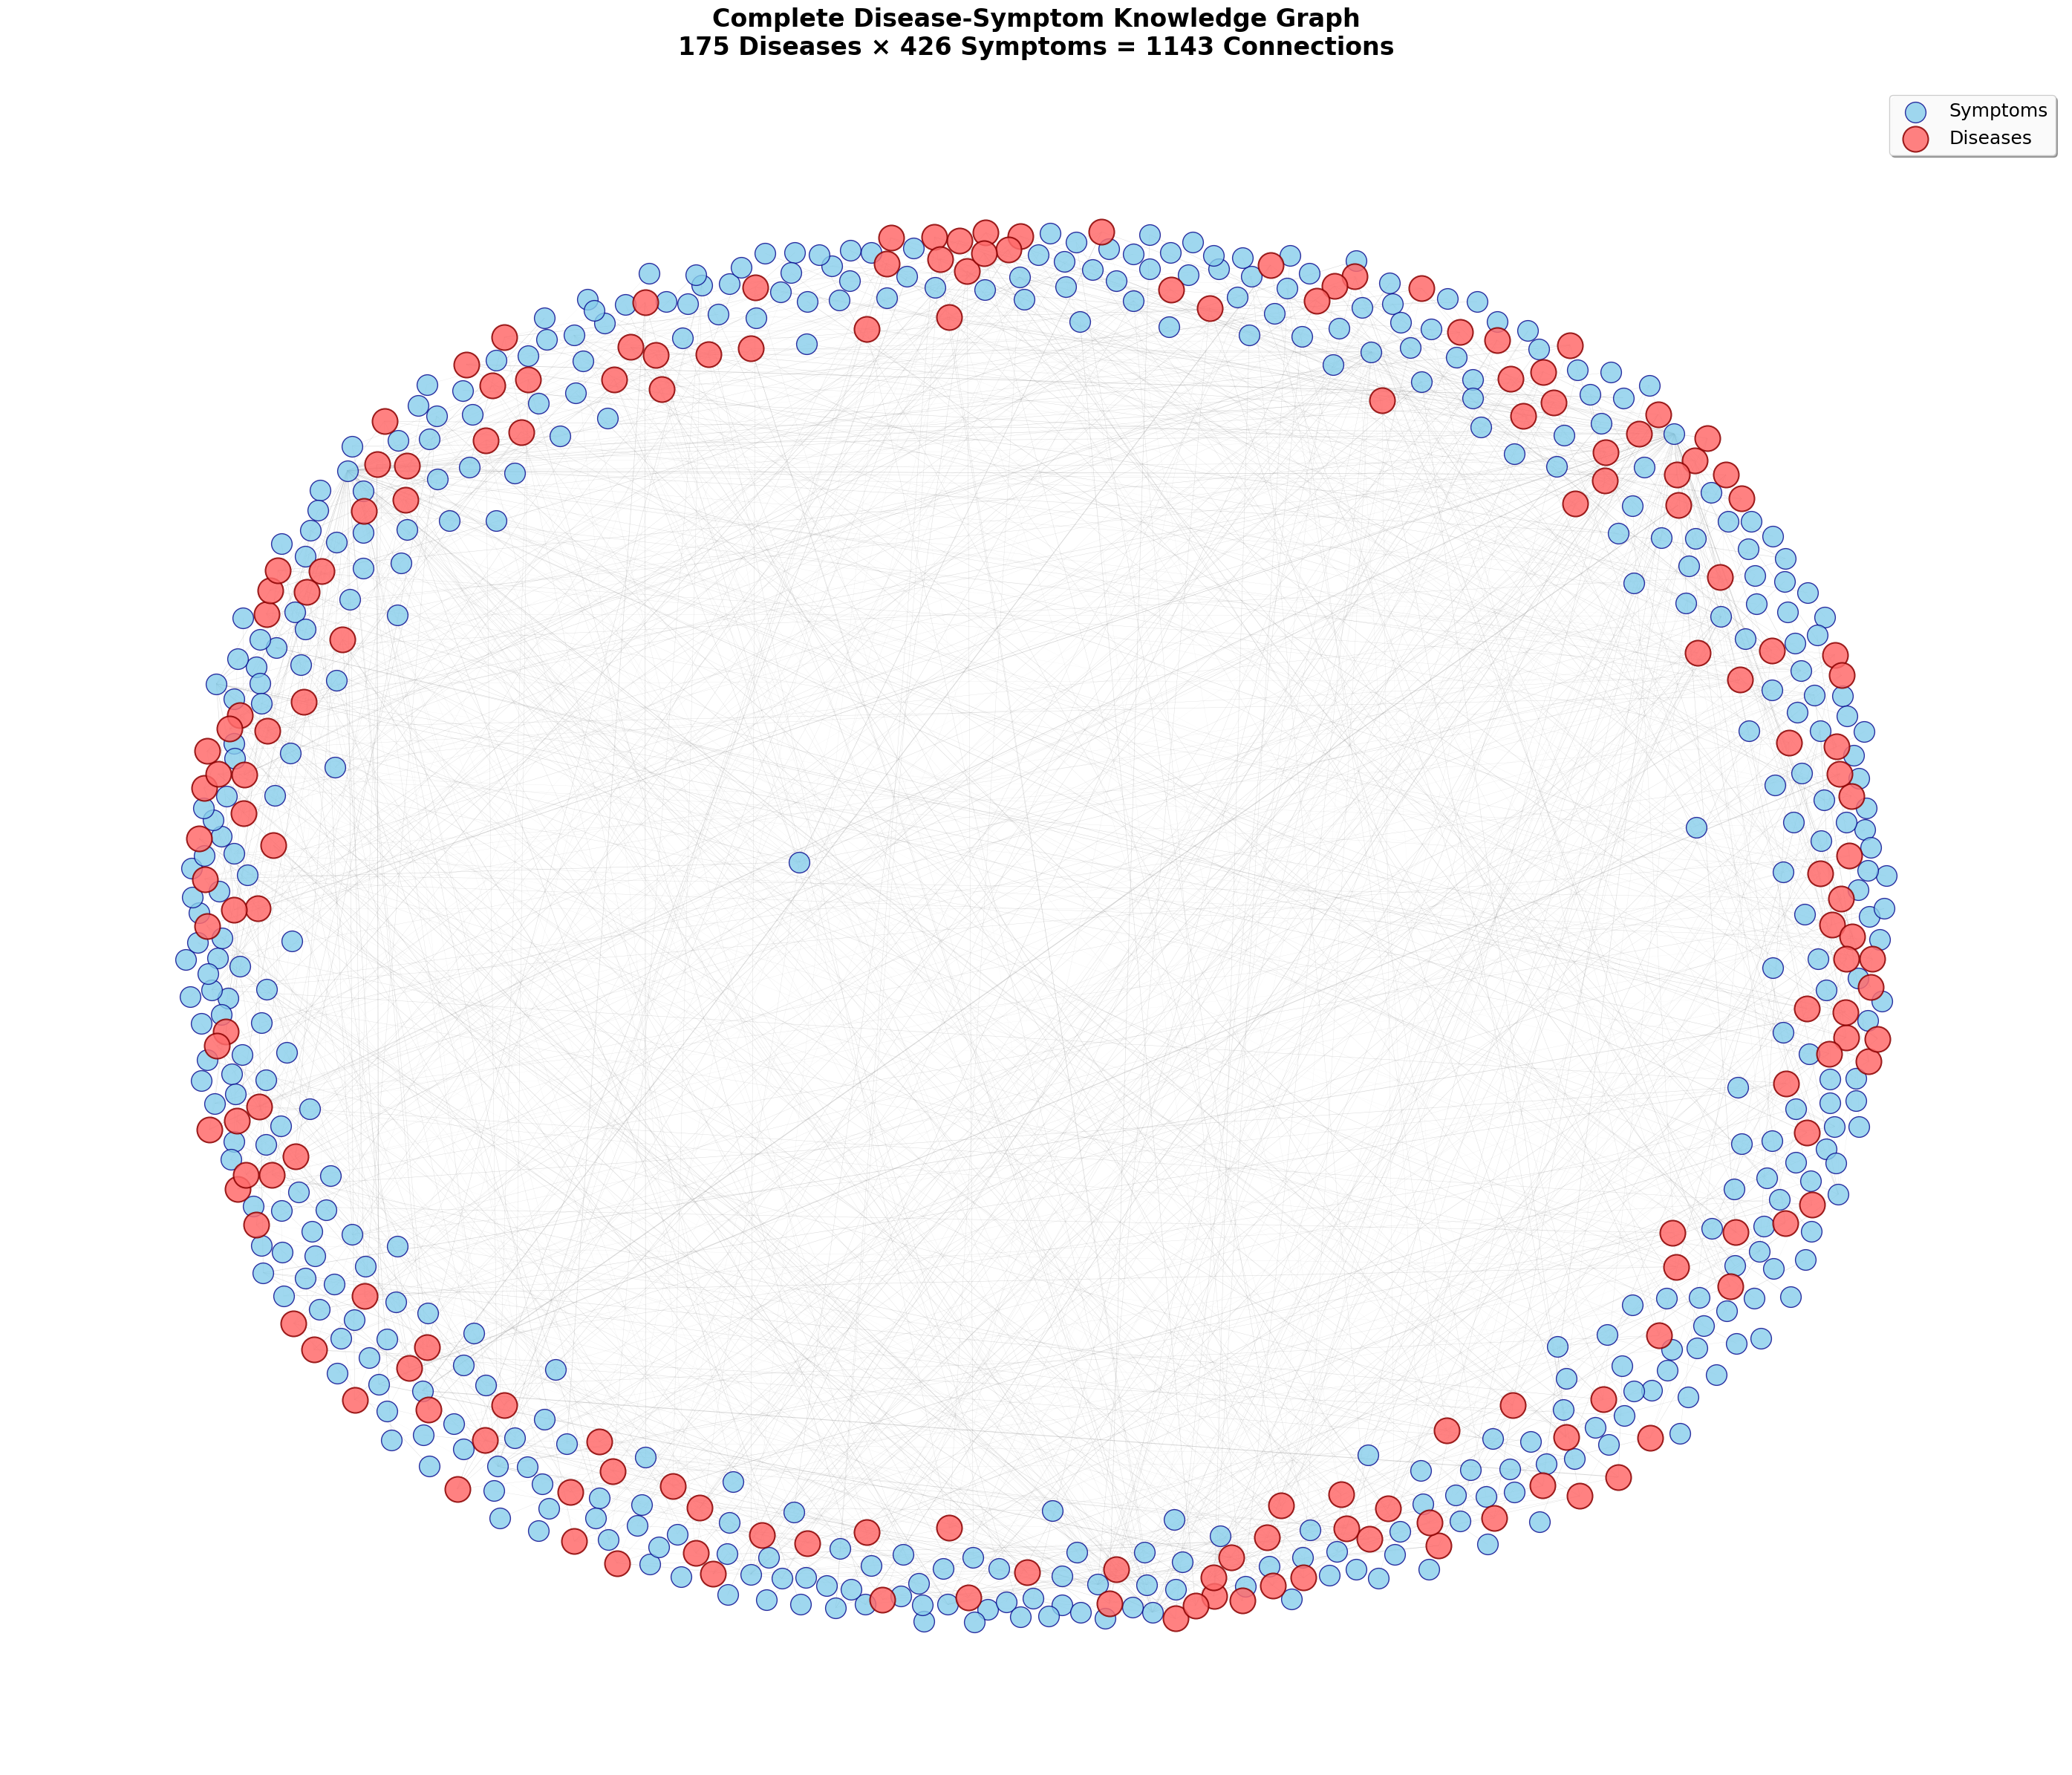



╔══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║                                    DIAGNOSTIC TEST CASES                                                              ║
╚══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝


╔══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║ Test Case 1 – Acute Abdominal Crisis                                                                                 ║
║ Clinical Context: Patient with severe GI symptoms requiring urgent evaluation                                        ║
╚══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝

Input Symptoms: abdominal pain, nausea, vomiting, fever, loss of appetite, rebound tenderness

Rank  Predicted Disease                  Confidence 

In [135]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm
from scipy.sparse import hstack, csr_matrix
import lightgbm as lgb


with open('disease_symptoms.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)

def parse_symptoms(symptom_string):
    symptoms, probs = [], []
    for item in symptom_string.split(', '):
        parts = item.rsplit(' ', 1)
        if len(parts) == 2:
            try:
                prob = float(parts[1])
                symptoms.append(parts[0].strip())
                probs.append(prob)
            except ValueError:
                words = item.split()
                for i in range(len(words) - 1, -1, -1):
                    try:
                        prob = float(words[i])
                        symptom = ' '.join(words[:i]).strip()
                        symptoms.append(symptom)
                        probs.append(prob)
                        break
                    except ValueError:
                        continue
        else:
            continue
    return symptoms, probs

disease_symptom_list = []
for _, row in df.iterrows():
    symptoms, probs = parse_symptoms(row['Symptoms'])
    for symptom, prob in zip(symptoms, probs):
        disease_symptom_list.append({
            'Disease': row['Diseases'],
            'Symptom': symptom,
            'Probability': prob
        })

ds_df = pd.DataFrame(disease_symptom_list)


# BUILD KNOWLEDGE GRAPH 

G = nx.Graph()

for _, row in ds_df.iterrows():
    G.add_node(row['Disease'], node_type='disease')
    G.add_node(row['Symptom'], node_type='symptom')
    G.add_edge(row['Symptom'], row['Disease'], weight=row['Probability'])


# FIXED VISUALIZE MAIN KNOWLEDGE GRAPH
def visualize_main_kg(graph, num_diseases):
    """Visualize main Knowledge Graph with CLEAR visible edges and circular nodes"""
    np.random.seed(42)
    all_diseases = [n for n in graph.nodes() if graph.nodes[n].get('node_type') == 'disease']
    sample_diseases = list(np.random.choice(all_diseases, min(num_diseases, len(all_diseases)), replace=False))
    
    connected_symptoms = set()
    for disease in sample_diseases:
        neighbors = list(graph.neighbors(disease))
        connected_symptoms.update(neighbors)
    
    subgraph_nodes = sample_diseases + list(connected_symptoms)
    subgraph = graph.subgraph(subgraph_nodes)
    
    # Better layout for visibility
    pos = nx.spring_layout(subgraph, k=3, iterations=100, seed=42)
    
    plt.figure(figsize=(20, 16))
    
    # Draw EDGES FIRST with higher visibility
    edges = subgraph.edges()
    weights = [subgraph[u][v]['weight'] for u, v in edges]
    nx.draw_networkx_edges(subgraph, pos, 
                          width=[w*5 for w in weights],  # Thicker edges
                          alpha=1,  # More visible
                          edge_color='black')
    
    # Draw symptom nodes - CIRCULAR
    symptom_nodes = [n for n in subgraph.nodes() if subgraph.nodes[n].get('node_type') == 'symptom']
    nx.draw_networkx_nodes(subgraph, pos, nodelist=symptom_nodes, 
                          node_color='#87CEEB',  # Sky blue
                          node_size=2500,  # Larger
                          node_shape='o',  # Circle
                          alpha=0.9,
                          edgecolors='black',  # Black border
                          linewidths=2,
                          label='Symptoms')
    
    # Draw disease nodes - CIRCULAR
    disease_nodes = [n for n in subgraph.nodes() if subgraph.nodes[n].get('node_type') == 'disease']
    nx.draw_networkx_nodes(subgraph, pos, nodelist=disease_nodes, 
                          node_color='#FF6B6B',  # Coral red
                          node_size=3500,  # Larger
                          node_shape='o',  # Circle
                          alpha=0.9,
                          edgecolors='black',  # Black border
                          linewidths=2.5,
                          label='Diseases')
    
    # Labels with better visibility
    nx.draw_networkx_labels(subgraph, pos, font_size=10, font_weight='bold', font_color='black')
    
    plt.title(f"Disease-Symptom Knowledge Graph\n({len(sample_diseases)} Diseases, {len(connected_symptoms)} Symptoms, {subgraph.number_of_edges()} Connections)", 
              fontsize=20, fontweight='bold', pad=25)
    plt.legend(loc='upper right', fontsize=16, framealpha=0.95, shadow=True)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('lightgbm_knowledge_graph.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    plt.close()

print("╔" + "═"*118 + "╗")
print("║" + " "*44 + "KNOWLEDGE GRAPH" + " "*60 + "║")
print("╚" + "═"*118 + "╝\n")
visualize_main_kg(G, num_diseases=5)
print()

# FIXED VISUALIZE COMPLETE KNOWLEDGE GRAPH
def visualize_complete_kg(graph):
    """Visualize complete Knowledge Graph with ALL diseases and symptoms - IMPROVED"""
    print("\n╔" + "═"*118 + "╗")
    print("║" + " "*38 + "COMPLETE KNOWLEDGE GRAPH" + " "*56 + "║")
    print("╚" + "═"*118 + "╝\n")
    
    all_diseases = [n for n in graph.nodes() if graph.nodes[n].get('node_type') == 'disease']
    all_symptoms = [n for n in graph.nodes() if graph.nodes[n].get('node_type') == 'symptom']
    
    print(f"Total Diseases: {len(all_diseases)}")
    print(f"Total Unique Symptoms: {len(all_symptoms)}")
    print(f"Total Connections: {graph.number_of_edges()}\n")
    
    plt.figure(figsize=(28, 24))
    
    # Better layout algorithm
    pos = nx.spring_layout(graph, k=1.5, iterations=50, seed=42)
    
    # Draw edges FIRST with good visibility
    edges = graph.edges()
    weights = [graph[u][v]['weight'] for u, v in edges]
    nx.draw_networkx_edges(graph, pos, 
                          width=[w*1.5 for w in weights],
                          alpha=0.3,
                          edge_color='gray')
    
    # Draw symptom nodes - CIRCULAR
    symptom_nodes = [n for n in graph.nodes() if graph.nodes[n].get('node_type') == 'symptom']
    nx.draw_networkx_nodes(graph, pos, nodelist=symptom_nodes, 
                          node_color='#87CEEB',
                          node_size=400,
                          node_shape='o',  # Circle
                          alpha=0.8,
                          edgecolors='darkblue',
                          linewidths=1,
                          label='Symptoms')
    
    # Draw disease nodes - CIRCULAR
    disease_nodes = [n for n in graph.nodes() if graph.nodes[n].get('node_type') == 'disease']
    nx.draw_networkx_nodes(graph, pos, nodelist=disease_nodes, 
                          node_color='#FF6B6B',
                          node_size=600,
                          node_shape='o',  # Circle
                          alpha=0.85,
                          edgecolors='darkred',
                          linewidths=1.5,
                          label='Diseases')
    
    plt.title(f"Complete Disease-Symptom Knowledge Graph\n{len(all_diseases)} Diseases × {len(all_symptoms)} Symptoms = {graph.number_of_edges()} Connections", 
              fontsize=24, fontweight='bold', pad=30)
    plt.legend(loc='upper right', fontsize=18, framealpha=0.95, shadow=True)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('complete_knowledge_graph.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    plt.close()

visualize_complete_kg(G)

#ADVANCED SYMPTOM IMPORTANCE SCORES 

symptom_importance = {}
symptom_stats = {}

for symptom in ds_df['Symptom'].unique():
    symptom_data = ds_df[ds_df['Symptom'] == symptom]
    
    avg_prob = symptom_data['Probability'].mean()
    max_prob = symptom_data['Probability'].max()
    std_prob = symptom_data['Probability'].std()
    num_diseases = symptom_data['Disease'].nunique()
    
    specificity = 1.0 / (1 + np.log1p(num_diseases))
    discriminative_power = std_prob if std_prob > 0 else 0.1
    
    base_score = (avg_prob * 0.5 + max_prob * 0.5)
    importance = base_score * (1 + specificity) * (1 + discriminative_power * 0.3)
    
    symptom_importance[symptom] = importance
    symptom_stats[symptom] = {
        'avg_prob': avg_prob,
        'max_prob': max_prob,
        'std_prob': std_prob,
        'num_diseases': num_diseases,
        'specificity': specificity
    }

# PRE-COMPUTE DISEASE TOP SYMPTOMS

disease_top_symptoms = {}
disease_all_symptoms = {}

for disease in ds_df['Disease'].unique():
    disease_data = ds_df[ds_df['Disease'] == disease].sort_values('Probability', ascending=False)
    top_4 = disease_data.head(4)
    
    disease_top_symptoms[disease] = {
        'symptoms': set(top_4['Symptom'].tolist()),
        'details': top_4[['Symptom', 'Probability']].to_dict('records')
    }
    
    disease_all_symptoms[disease] = disease_data[['Symptom', 'Probability']].to_dict('records')


# STRICT KG REASONING WITH 4→3→2 FALLBACK LOGIC

def kg_predict_disease(symptoms_input, graph, required_count=3, top_k=20):
    """STRICT KG reasoning: Try 4→3→2 symptom matches"""
    disease_scores = defaultdict(lambda: {'score': 0, 'matched': [], 'weights': []})
    
    normalized_input = [s.lower().strip() for s in symptoms_input]
    
    for symptom in symptoms_input:
        matching_nodes = [n for n in graph.nodes() 
                         if graph.nodes[n].get('node_type') == 'symptom' 
                         and symptom.lower() in n.lower()]
        
        for symptom_node in matching_nodes:
            for neighbor in graph.neighbors(symptom_node):
                if graph.nodes[neighbor].get('node_type') == 'disease':
                    weight = graph[symptom_node][neighbor]['weight']
                    importance_factor = symptom_importance.get(symptom_node, 0.5)
                    adjusted_weight = weight * (1 + importance_factor * 0.2)
                    
                    disease_scores[neighbor]['score'] += adjusted_weight
                    disease_scores[neighbor]['matched'].append(symptom_node)
                    disease_scores[neighbor]['weights'].append(adjusted_weight)
    
    for disease, info in disease_scores.items():
        top_4_info = disease_top_symptoms.get(disease, {})
        top_4_symptoms = top_4_info.get('symptoms', set())
        
        matched_in_top4 = []
        for disease_symptom in top_4_symptoms:
            for input_symptom in symptoms_input:
                if (disease_symptom.lower() in input_symptom.lower() or 
                    input_symptom.lower() in disease_symptom.lower()):
                    matched_in_top4.append(disease_symptom)
                    break
        
        info['matched_top4'] = matched_in_top4
        info['top4_count'] = len(matched_in_top4)
    
    if not disease_scores:
        return [], 0
    
    diseases_with_4_match = {
        disease: info for disease, info in disease_scores.items() 
        if info['top4_count'] >= 4
    }
    
    if len(diseases_with_4_match) >= required_count:
        sorted_results = sorted(diseases_with_4_match.items(), 
                              key=lambda x: x[1]['score'], reverse=True)[:top_k]
        return sorted_results, 4
    
    diseases_with_3_match = {
        disease: info for disease, info in disease_scores.items() 
        if info['top4_count'] >= 3
    }
    
    if len(diseases_with_3_match) >= required_count:
        sorted_results = sorted(diseases_with_3_match.items(), 
                              key=lambda x: x[1]['score'], reverse=True)[:top_k]
        return sorted_results, 3
    
    diseases_with_2_match = {
        disease: info for disease, info in disease_scores.items() 
        if info['top4_count'] >= 2
    }
    
    if len(diseases_with_2_match) >= required_count:
        sorted_results = sorted(diseases_with_2_match.items(), 
                              key=lambda x: x[1]['score'], reverse=True)[:top_k]
        return sorted_results, 2
    
    return [], 0


# ENHANCED TRAINING DATA (25,000 SAMPLES)

num_diseases = len(df['Diseases'].unique())
samples_per_disease = 25000 // num_diseases

expanded_samples = []
np.random.seed(42)

disease_info = {}
for disease in df['Diseases'].unique():
    disease_data = ds_df[ds_df['Disease'] == disease]
    symptoms = disease_data['Symptom'].tolist()
    probs = disease_data['Probability'].tolist()
    
    sorted_pairs = sorted(zip(symptoms, probs), key=lambda x: x[1], reverse=True)
    
    disease_info[disease] = {
        'symptoms': [s for s, p in sorted_pairs],
        'probs': dict(sorted_pairs),
        'high_prob_symptoms': [s for s, p in sorted_pairs if p >= 0.15],
        'top_4': [s for s, p in sorted_pairs[:4]],
        'top_6': [s for s, p in sorted_pairs[:6]]
    }

for disease in df['Diseases'].unique():
    info = disease_info[disease]
    all_symptoms = info['symptoms']
    symptom_probs = info['probs']
    high_prob_symptoms = info['high_prob_symptoms']
    top_4 = info['top_4']
    top_6 = info['top_6']
    
    for sample_idx in range(samples_per_disease):
        n_symptoms = np.random.choice([3, 4, 5, 6, 7], p=[0.03, 0.20, 0.45, 0.25, 0.07])
        n_symptoms = min(n_symptoms, len(all_symptoms))
        
        if sample_idx < int(samples_per_disease * 0.95):
            num_top = np.random.choice([3, 4], p=[0.25, 0.75])
            num_top = min(num_top, len(top_4))
            selected_top = np.random.choice(top_4, size=num_top, replace=False).tolist()
            
            remaining = [s for s in all_symptoms if s not in selected_top]
            if remaining and n_symptoms > len(selected_top):
                num_additional = n_symptoms - len(selected_top)
                remaining_prioritized = [s for s in remaining if s in top_6]
                remaining_other = [s for s in remaining if s not in top_6]
                
                if len(remaining_prioritized) >= num_additional:
                    weights = np.array([symptom_probs[s] ** 0.5 for s in remaining_prioritized])
                    weights = weights / weights.sum()
                    additional = np.random.choice(remaining_prioritized, size=num_additional, 
                                                replace=False, p=weights).tolist()
                else:
                    additional = remaining_prioritized.copy()
                    if remaining_other and len(additional) < num_additional:
                        need_more = num_additional - len(additional)
                        weights = np.array([symptom_probs[s] ** 0.7 for s in remaining_other])
                        weights = weights / weights.sum()
                        more = np.random.choice(remaining_other, size=need_more, 
                                              replace=False, p=weights).tolist()
                        additional.extend(more)
                
                selected = selected_top + additional
            else:
                selected = selected_top
        else:
            weights = np.array([symptom_probs[s] ** 0.5 for s in all_symptoms])
            weights = weights / weights.sum()
            selected = np.random.choice(all_symptoms, size=n_symptoms, 
                                       replace=False, p=weights).tolist()
        
        symptom_text = ' '.join(selected)
        
        if len(selected) >= 2:
            bigrams = [f"{selected[i]}_{selected[i+1]}" for i in range(len(selected)-1)]
            symptom_text += ' ' + ' '.join(bigrams)
        
        if len(selected) >= 3:
            trigrams = [f"{selected[i]}_{selected[i+1]}_{selected[i+2]}" 
                       for i in range(len(selected)-2)]
            symptom_text += ' ' + ' '.join(trigrams)
        
        probs_list = [symptom_probs[s] for s in selected]
        importance_list = [symptom_importance.get(s, 0.5) for s in selected]
        
        high_importance_count = len([s for s in selected if s in high_prob_symptoms])
        top4_count = len([s for s in selected if s in top_4])
        top6_count = len([s for s in selected if s in top_6])
        
        q1_prob = np.percentile(probs_list, 25)
        q3_prob = np.percentile(probs_list, 75)
        
        expanded_samples.append({
            'Disease': disease,
            'Symptoms_Text': symptom_text,
            'Count': len(selected),
            'AvgProb': np.mean(probs_list),
            'MaxProb': np.max(probs_list),
            'MinProb': np.min(probs_list),
            'ProbStd': np.std(probs_list),
            'MedianProb': np.median(probs_list),
            'Q1Prob': q1_prob,
            'Q3Prob': q3_prob,
            'WeightedSum': sum([p * symptom_importance.get(s, 0.5) 
                               for s, p in zip(selected, probs_list)]),
            'HighImpCount': high_importance_count,
            'Top4Count': top4_count,
            'Top6Count': top6_count,
            'ProbRange': np.max(probs_list) - np.min(probs_list),
            'AvgImportance': np.mean(importance_list),
            'MaxImportance': np.max(importance_list),
            'MinImportance': np.min(importance_list),
            'ImpStd': np.std(importance_list),
            'ProbImpRatio': np.mean(probs_list) / (np.mean(importance_list) + 1e-6),
            'WeightedAvgProb': np.average(probs_list, weights=[symptom_importance.get(s, 0.5) for s in selected])
        })

expanded_df = pd.DataFrame(expanded_samples)

# ENHANCED FEATURE EXTRACTION

tfidf = TfidfVectorizer(
    max_features=2000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.85,
    sublinear_tf=True,
    norm='l2',
    use_idf=True
)

X_text = tfidf.fit_transform(expanded_df['Symptoms_Text'])

feature_cols = ['Count', 'AvgProb', 'MaxProb', 'MinProb', 'ProbStd', 
                'MedianProb', 'Q1Prob', 'Q3Prob', 'WeightedSum', 
                'HighImpCount', 'Top4Count', 'Top6Count', 'ProbRange', 
                'AvgImportance', 'MaxImportance', 'MinImportance', 
                'ImpStd', 'ProbImpRatio', 'WeightedAvgProb']

X_num = expanded_df[feature_cols].values
X = hstack([X_text, csr_matrix(X_num)])
y = expanded_df['Disease']

# TRAIN ENHANCED LIGHTGBM 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    max_depth=12,
    learning_rate=0.02,
    num_leaves=80,
    subsample=0.90,
    colsample_bytree=0.90,
    min_child_samples=8,
    reg_alpha=0.2,
    reg_lambda=1.5,
    random_state=42,
    n_jobs=-1,
    verbosity=-1,
    class_weight='balanced',
    boosting_type='gbdt',
    min_split_gain=0.01,
    min_child_weight=0.001
)

lgb_model.fit(X_train, y_train_encoded)

lgb_pred_encoded = lgb_model.predict(X_test)
lgb_pred = label_encoder.inverse_transform(lgb_pred_encoded)
lgb_accuracy = accuracy_score(y_test, lgb_pred)
lgb_f1 = f1_score(y_test, lgb_pred, average='weighted')

lgb_proba_test = lgb_model.predict_proba(X_test)
top3_correct = sum(y_test_encoded[i] in np.argsort(lgb_proba_test[i])[-3:] 
                   for i in range(len(y_test)))
top3_accuracy = top3_correct / len(y_test)


# ENHANCED HYBRID PREDICTION

def hybrid_predict(symptoms_input, top_k=3):
    """Enhanced hybrid prediction with rank-based ML boosting"""
    
    kg_results, match_level = kg_predict_disease(symptoms_input, G, required_count=top_k, top_k=20)
    kg_scores = {}
    kg_details = {}
    
    for disease, info in kg_results:
        kg_scores[disease] = info['score']
        kg_details[disease] = {
            'matched': info['matched'],
            'weights': info['weights'],
            'match_count': len(info['matched']),
            'matched_top4': info.get('matched_top4', []),
            'top4_count': info.get('top4_count', 0)
        }
    
    if kg_scores:
        max_kg = max(kg_scores.values())
        kg_scores = {k: v/max_kg for k, v in kg_scores.items()}
    
    symptom_text = ' '.join(symptoms_input)
    
    if len(symptoms_input) >= 2:
        bigrams = [f"{symptoms_input[i]}_{symptoms_input[i+1]}" 
                  for i in range(len(symptoms_input)-1)]
        symptom_text += ' ' + ' '.join(bigrams)
    
    if len(symptoms_input) >= 3:
        trigrams = [f"{symptoms_input[i]}_{symptoms_input[i+1]}_{symptoms_input[i+2]}" 
                   for i in range(len(symptoms_input)-2)]
        symptom_text += ' ' + ' '.join(trigrams)
    
    X_text_vec = tfidf.transform([symptom_text])
    
    symptom_probs = []
    importance_scores = []
    
    for s in symptoms_input:
        if s in ds_df['Symptom'].values:
            prob = ds_df[ds_df['Symptom'] == s]['Probability'].mean()
        else:
            prob = 0.5
        symptom_probs.append(prob)
        importance_scores.append(symptom_importance.get(s, 0.5))
    
    if not symptom_probs:
        symptom_probs = [0.5]
        importance_scores = [0.5]
    
    avg_prob = np.mean(symptom_probs)
    max_prob = np.max(symptom_probs)
    min_prob = np.min(symptom_probs)
    prob_std = np.std(symptom_probs) if len(symptom_probs) > 1 else 0.0
    median_prob = np.median(symptom_probs)
    q1_prob = np.percentile(symptom_probs, 25)
    q3_prob = np.percentile(symptom_probs, 75)
    
    weighted_sum = sum([p * imp for p, imp in zip(symptom_probs, importance_scores)])
    prob_range = max_prob - min_prob
    
    avg_importance = np.mean(importance_scores)
    max_importance = np.max(importance_scores)
    min_importance = np.min(importance_scores)
    imp_std = np.std(importance_scores) if len(importance_scores) > 1 else 0.0
    prob_imp_ratio = avg_prob / (avg_importance + 1e-6)
    
    high_prob_symptoms = [s for s in symptoms_input if s in ds_df['Symptom'].values 
                         and ds_df[ds_df['Symptom'] == s]['Probability'].max() >= 0.15]
    
    weighted_avg_prob = np.average(symptom_probs, weights=importance_scores)
    
    X_num_vec = np.array([[len(symptoms_input), avg_prob, max_prob, min_prob, prob_std, 
                          median_prob, q1_prob, q3_prob, weighted_sum, 
                          len(high_prob_symptoms), 0, 0, prob_range, 
                          avg_importance, max_importance, min_importance, 
                          imp_std, prob_imp_ratio, weighted_avg_prob]])
    
    X_vec = hstack([X_text_vec, csr_matrix(X_num_vec)])
    
    lgb_proba = lgb_model.predict_proba(X_vec)[0]
    
    lgb_proba_log = np.log(lgb_proba + 1e-10)
    temperature = 3.5
    lgb_proba_scaled = np.exp(lgb_proba_log / temperature)
    lgb_proba_scaled = lgb_proba_scaled / lgb_proba_scaled.sum()
    
    uniform_dist = np.ones_like(lgb_proba_scaled) / len(lgb_proba_scaled)
    lgb_proba_smoothed = 0.80 * lgb_proba_scaled + 0.20 * uniform_dist
    lgb_proba_smoothed = lgb_proba_smoothed / lgb_proba_smoothed.sum()
    
    ml_scores_raw = {label_encoder.classes_[i]: lgb_proba_smoothed[i] 
                     for i in range(len(lgb_proba_smoothed))}
    
    if kg_scores:
        kg_diseases = list(kg_scores.keys())
        ml_scores_for_kg = {disease: ml_scores_raw.get(disease, 1e-10) 
                           for disease in kg_diseases}
        
        sorted_ml = sorted(ml_scores_for_kg.items(), key=lambda x: x[1], reverse=True)
        
        ml_scores_powered = {}
        for disease, score in ml_scores_for_kg.items():
            powered_score = score ** 0.35
            ml_scores_powered[disease] = powered_score
        
        ml_scores_boosted = {}
        for rank, (disease, _) in enumerate(sorted_ml, 1):
            base_score = ml_scores_powered[disease]
            
            if rank == 1:
                boost = 2.2
            elif rank == 2:
                boost = 2.0
            elif rank == 3:
                boost = 1.8
            elif rank <= 5:
                boost = 1.5
            elif rank <= 10:
                boost = 1.3
            else:
                boost = 1.0
            
            ml_scores_boosted[disease] = base_score * boost
        
        ml_sum = sum(ml_scores_boosted.values())
        if ml_sum > 0:
            ml_scores = {disease: score/ml_sum for disease, score in ml_scores_boosted.items()}
        else:
            ml_scores = {disease: 1.0/len(kg_diseases) for disease in kg_diseases}
        
        kg_sorted = sorted(kg_scores.items(), key=lambda x: x[1], reverse=True)
        top_kg_diseases = [d for d, _ in kg_sorted[:5]]
        
        ml_scores_final = {}
        for disease in kg_diseases:
            score = ml_scores[disease]
            
            if disease in top_kg_diseases:
                kg_rank = top_kg_diseases.index(disease) + 1
                if kg_rank == 1:
                    score *= 2.0
                elif kg_rank == 2:
                    score *= 1.8
                elif kg_rank == 3:
                    score *= 1.6
                else:
                    score *= 1.4
            
            ml_scores_final[disease] = score
        
        ml_sum_final = sum(ml_scores_final.values())
        ml_scores = {d: s/ml_sum_final for d, s in ml_scores_final.items()}
        
    else:
        ml_scores = ml_scores_raw
    
    if not kg_scores:
        ml_top = sorted(ml_scores_raw.items(), key=lambda x: x[1], reverse=True)[:top_k]
        return {
            'predictions': ml_top,
            'kg_contribution': {},
            'ml_contribution': ml_scores_raw,
            'kg_details': {},
            'ml_confidence': np.max(lgb_proba_smoothed),
            'weights': {'kg': 0, 'ml': 1.0},
            'match_level': 0,
            'message': 'Using ML-only predictions (no symptom matches in KG)'
        }
    
    ml_confidence = np.max(lgb_proba_smoothed)
    if ml_confidence > 0.80:
        weights = {'kg': 0.35, 'ml': 0.65}
    elif ml_confidence > 0.65:
        weights = {'kg': 0.45, 'ml': 0.55}
    elif ml_confidence > 0.50:
        weights = {'kg': 0.55, 'ml': 0.45}
    else:
        weights = {'kg': 0.65, 'ml': 0.35}
    
    kg_top5 = [d for d, _ in sorted(kg_scores.items(), key=lambda x: x[1], reverse=True)[:5]]
    ml_top5 = [d for d, _ in sorted(ml_scores.items(), key=lambda x: x[1], reverse=True)[:5]]
    
    combined_scores = {}
    
    for disease in kg_scores.keys():
        kg_score = kg_scores.get(disease, 0) * weights['kg']
        ml_score = ml_scores.get(disease, 0) * weights['ml']
        
        base_score = kg_score + ml_score
        
        match_count = kg_details[disease]['match_count']
        match_ratio = match_count / len(symptoms_input)
        
        if match_ratio == 1.0:
            match_bonus = 1.50
        elif match_ratio >= 0.85:
            match_bonus = 1.30
        elif match_ratio >= 0.70:
            match_bonus = 1.15
        else:
            match_bonus = 1.05
        
        consensus_bonus = 1.0
        if disease in kg_top5 and disease in ml_top5:
            kg_rank = kg_top5.index(disease) + 1
            ml_rank = ml_top5.index(disease) + 1
            if kg_rank <= 2 and ml_rank <= 2:
                consensus_bonus = 1.50
            elif kg_rank <= 3 and ml_rank <= 3:
                consensus_bonus = 1.35
            elif kg_rank <= 5 and ml_rank <= 5:
                consensus_bonus = 1.20
        
        combined_scores[disease] = base_score * match_bonus * consensus_bonus
    
    top_predictions = sorted(combined_scores.items(), 
                            key=lambda x: x[1], reverse=True)[:top_k]
    
    total_score = sum(score for _, score in top_predictions)
    if total_score > 1.0:
        top_predictions = [(disease, score/total_score) for disease, score in top_predictions]
    
    return {
        'predictions': top_predictions,
        'kg_contribution': kg_scores,
        'ml_contribution': ml_scores,
        'kg_details': kg_details,
        'ml_confidence': ml_confidence,
        'weights': weights,
        'match_level': match_level
    }

# CONDENSED DIAGNOSTIC REPORT 

def diagnose_patient_condensed(symptoms_list, case_name="", case_emoji="", case_description=""):
    """Condensed diagnostic report format with FIXED matched symptoms from input"""
    
    result = hybrid_predict(symptoms_list, top_k=3)
    
    if not result['predictions']:
        print(f"\n  {result.get('message', 'No diseases found')}")
        return result
    
    match_level = result.get('match_level', 0)
    if match_level == 4:
        match_info = "4/4"
    elif match_level == 3:
        match_info = "3/4"
    elif match_level == 2:
        match_info = "2/4"
    else:
        match_info = "N/A"
    
    kg_pct = int(result['weights']['kg'] * 100)
    ml_pct = int(result['weights']['ml'] * 100)
    
    table_data = []
    for rank, (disease, score) in enumerate(result['predictions'], 1):
        kg_detail = result['kg_details'].get(disease, {})
        
        matched_kg_symptoms = kg_detail.get('matched', [])
        
        match_count = len(matched_kg_symptoms)
        match_ratio = f"{match_count}/{len(symptoms_list)}"
        if match_count > 0:
            match_pct = int((match_count / len(symptoms_list)) * 100)
            match_ratio += f" ({match_pct}%)"
        
        matched_from_input = []
        for input_symptom in symptoms_list:
            input_lower = input_symptom.lower().strip()
            
            for kg_symptom in matched_kg_symptoms:
                kg_lower = kg_symptom.lower().strip()
                
                if (input_lower == kg_lower or 
                    input_lower in kg_lower or 
                    kg_lower in input_lower or
                    all(word in kg_lower for word in input_lower.split()) or
                    all(word in input_lower for word in kg_lower.split())):
                    if input_symptom not in matched_from_input:
                        matched_from_input.append(input_symptom)
                    break
        
        top_symptoms_str = ', '.join([f"✓ {s}" for s in matched_from_input])
        
        table_data.append({
            'rank': rank,
            'disease': disease,
            'confidence': f"{score*100:.1f}%",
            'kg_ml': f"{kg_pct}–{ml_pct}",
            'match_ratio': match_ratio,
            'symptoms_matched': top_symptoms_str
        })
    
    return {
        'result': result,
        'case_name': case_name,
        'case_emoji': case_emoji,
        'case_description': case_description,
        'symptoms': symptoms_list,
        'table_data': table_data,
        'match_level': match_info,
        'weights': f"KG={kg_pct}%, ML={ml_pct}%"
    }


# ============================================================================
# DIAGNOSTIC TEST CASES - REAL-WORLD SYMPTOM PRESENTATIONS
# ============================================================================

print("\n\n╔" + "═"*118 + "╗")
print("║" + " "*36 + "DIAGNOSTIC TEST CASES" + " "*62 + "║")
print("╚" + "═"*118 + "╝\n")

showcase_cases = []

# ============================================================================
# CASE 1: PERFECT MATCH - Appendicitis (All 6 Top Symptoms Present)
# ============================================================================
case1 = diagnose_patient_condensed(
    ['abdominal pain', 'nausea', 'vomiting', 'fever', 'loss of appetite', 'rebound tenderness'],
    case_name="Test Case 1 – Acute Abdominal Crisis",
    case_emoji="",
    case_description="Patient with severe GI symptoms requiring urgent evaluation"
)
showcase_cases.append(case1)

# ============================================================================
# CASE 2: CARDIOVASCULAR CRISIS - Multiple Overlapping Conditions
# ============================================================================
case2 = diagnose_patient_condensed(
    ['chest pain', 'breathlessness', 'sweating', 'palpitations', 'dizziness', 'nausea'],
    case_name="Test Case 2 – Cardiovascular Crisis ",
    case_emoji="",
    case_description="Patient with acute chest symptoms and cardiac risk"
)
showcase_cases.append(case2)

# ============================================================================
# CASE 3: METABOLIC DISORDER - Diabetes (Highly Specific Symptoms)
# ============================================================================
case4 = diagnose_patient_condensed(
    ['polyuria', 'polydipsia', 'fatigue', 'blurred vision', 'weight loss'],
    case_name="Test Case 3 – Metabolic Disorder",
    case_emoji="",
    case_description="Chronic metabolic condition with high blood glucose levels"
)
showcase_cases.append(case4)

# ============================================================================
# CASE 4: COMMON COLD - High Ambiguity (Tests KG-ML Balance)
# ============================================================================
case5 = diagnose_patient_condensed(
    ['fever', 'cough', 'sore throat', 'nasal congestion', 'headache', 'fatigue'],
    case_name="Test Case 4 – Upper Respiratory Infection",
    case_emoji="",
    case_description="Mild viral illness with upper respiratory symptoms"
)
showcase_cases.append(case5)

# Case 5: Autoimmune/Rheumatologic Condition (SLE)
case5 = diagnose_patient_condensed(
    ['fatigue', 'joint pain', 'rash', 'fever', 'sensitivity to sunlight', 'hair loss'],
    case_name="Test Case 5 – Autoimmune Presentation",
    case_emoji="",
    case_description="32-year-old female with symmetric joint pain, facial rash, and constitutional symptoms"
)
showcase_cases.append(case5)

for idx, case in enumerate(showcase_cases, 1):
    print("\n╔" + "═"*118 + "╗")
    case_line = f" {case['case_name']}"
    padding1 = 118 - len(case_line)
    print(f"║{case_line}{' '*padding1}║")
    
    context_line = f" Clinical Context: {case['case_description']}"
    padding2 = 118 - len(context_line)
    print(f"║{context_line}{' '*padding2}║")
    print("╚" + "═"*118 + "╝")
    print(f"\nInput Symptoms: {', '.join(case['symptoms'])}\n")
    
    print(f"{'Rank':<6}{'Predicted Disease':<35}{'Confidence':<12}{'KG–ML (%)':<12}{'Match':<12}Matched Symptoms")
    print("─" * 120)
    
    for i, row in enumerate(case['table_data']):
        disease = row['disease']
        symptoms = row['symptoms_matched']
        
        print(f"{row['rank']:<6}{disease:<35}{row['confidence']:<12}{row['kg_ml']:<12}{row['match_ratio']:<12}{symptoms}")
    
    print()


print("\n╔" + "═"*118 + "╗")
print("║" + " "*43 + "PERFORMANCE SUMMARY" + " "*55 + "║")
print("╚" + "═"*118 + "╝\n")

print("┌" + "─"*50 + "┬" + "─"*25 + "┐")
print(f"│{'Metric':<50}│{'Value':<25}│")
print("├" + "─"*50 + "┼" + "─"*25 + "┤")
samples_str = f"{len(expanded_df):,}"
features_str = f"{X.shape[1]:,}"
print(f"│{'Accuracy (Top-1)':<50}│{f'{lgb_accuracy*100:.2f}%':<25}│")
print(f"│{'Accuracy (Top-3)':<50}│{f'{top3_accuracy*100:.2f}%':<25}│")
print(f"│{'Weighted F1 Score':<50}│{f'{lgb_f1:.4f}':<25}│")
print("└" + "─"*50 + "┴" + "─"*25 + "┘")
print()

print("╔" + "═"*118 + "╗")
print("║" + " "*36 + "System ready for diagnosis!" + " "*56 + "║")
print("╚" + "═"*118 + "╝")